<center><h1>Forest Cover Classification</h1></center>
<center><h3>Step 2. Extract, Transform, and Load</h3></center>
<center><img src="https://raw.githubusercontent.com/oliver-m-king/forest_cover_classification/main/tree_image.png" alt="Image by Freepik" width="500" height="500"></center>

<h3>The dataset</h3>

This dataset contains observations of a selection of geographic data on 30 x 30 meter cells located in the Roosevelt National Forest of northern Colorado.<br>
There are 581,012 observations of 12 independent variables.<br>
The aim of this project is to develop a model that can accurately predict what type of forest cover a 30m x 30m cell in any area <i>similar</i> to the Roosevelt National Forest has, based on measurements of it's elevation; aspect; distance to water, roads and firepoints; hillshade; and soil type.

Independent variables were derived from data originally obtained from US Geological Survey (USGS) and USFS data.

The dataset was sourced from the <a href="https://archive.ics.uci.edu/ml/datasets/Covertype">Center for Machine Learning and Intelligent Systems, University of California Irvine</a>

In [1]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import RobustScaler

# Define a color list for plotting
color_list = ["#68c4a4", "#ff8c64", "#90a4cc", "#e88cc4", "#ffdc2c", "#a8dc54", "#e8c494"]

# Define directory
data_dir = "C:\\Users\\oliki\\OneDrive\\Forest Cover Classification\\"

<h3>Extract data</h3>

The data is imported from the .pkl outputted in the <i>Initial Data Exploration</i> phase.

In [2]:
# Import data
file_name = "decoded_cover_type.pkl"
decoded_df = pd.read_pickle(data_dir + file_name)

print("The dataset has {} rows, and {} columns".format(decoded_df.shape[0], decoded_df.shape[1]))

# Display the first five rows
decoded_df.head()

The dataset has 581012 rows, and 12 columns


,elevation,slope,hor_dist_to_hydro,ver_dist_to_hydro,hor_dist_to_road,hor_dist_to_fire,hillshade_9am,hillshade_noon,hillshade_3pm,aspect,soil_type,cover_type
0,2173,28,124,100,212,552,219,167,64,ne,cathedral_2702,ponderosa_pine
1,2161,32,458,142,524,390,254,188,34,se,cathedral_2702,ponderosa_pine
2,2110,25,342,150,390,466,225,177,71,ne,cathedral_2702,ponderosa_pine
3,2206,33,210,144,201,361,229,155,31,ne,cathedral_2702,ponderosa_pine
4,2132,27,365,172,408,488,239,179,53,e,cathedral_2702,ponderosa_pine


In [3]:
# Review data-types, and non-null value counts
decoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   elevation          581012 non-null  int64 
 1   slope              581012 non-null  int64 
 2   hor_dist_to_hydro  581012 non-null  int64 
 3   ver_dist_to_hydro  581012 non-null  int64 
 4   hor_dist_to_road   581012 non-null  int64 
 5   hor_dist_to_fire   581012 non-null  int64 
 6   hillshade_9am      581012 non-null  int64 
 7   hillshade_noon     581012 non-null  int64 
 8   hillshade_3pm      581012 non-null  int64 
 9   aspect             581012 non-null  object
 10  soil_type          581012 non-null  object
 11  cover_type         581012 non-null  object
dtypes: int64(9), object(3)
memory usage: 53.2+ MB


<h3>Transform data</h3>

Two transformations are performed:
1. To correct for the skew identified in the <i>Exploratory Data Analysis</i> phase, Box-Cox transformations are performed on all quantitative features. Box-Cox requires strictly positive data so <i>ver_dist_to_hydro</i>, which is the only feature that contains negatve values, is transformed to contain its absolute value; it is a measure of distance, not direction,so no explanatory value should be lost by this. Additionally, 0.01 is added to every observation of every qualitative feature to ensure that are no values of 0

2. Scaling is is performed using RobustScaler to correct for the subtantially different scales between the different qualitative features.

In [4]:
# Display skew of discrete features
discrete_features = decoded_df.select_dtypes(include=["int64"]).columns.to_list()
skew_list = []
for feature in discrete_features:
    skew = decoded_df[feature].skew()
    skew_list.append(skew)
    
skew_df = pd.DataFrame({"feature":discrete_features, "skew":skew_list})
skew_df.sort_values(by=["skew"])

,feature,skew
6,hillshade_9am,-1.181147
7,hillshade_noon,-1.063056
0,elevation,-0.817596
8,hillshade_3pm,-0.277053
4,hor_dist_to_road,0.713679
1,slope,0.789273
2,hor_dist_to_hydro,1.140437
5,hor_dist_to_fire,1.288644
3,ver_dist_to_hydro,1.790250


In [5]:
# Iterate through features and apply transformation

# Convert data such that it is strictly positive
transformed_df = decoded_df.copy()
transformed_df["ver_dist_to_hydro"] = transformed_df["ver_dist_to_hydro"].apply(lambda x: abs(x))

# Iterate through features, apply transformation, and store boxcox coefficient
boxcox_coefs = []
for feature in skew_df["feature"].to_list():
    transformed_df[feature] = transformed_df[feature].apply(lambda x: x + 0.01)
    boxcox = stats.boxcox(transformed_df[feature])
    transformed_df[feature] = boxcox[0]
    boxcox_coefs.append(boxcox[1])

# Create dataframe storing boxcox coefficients and output to pkl
boxcox_df = pd.DataFrame(boxcox_coefs, index = skew_df["feature"].to_list(), columns=["boxcox_coef"])
file_name = "boxcox_coefs.pkl"
boxcox_df.to_pickle(data_dir + file_name)
    
transformed_df.head()

,elevation,slope,hor_dist_to_hydro,ver_dist_to_hydro,hor_dist_to_road,hor_dist_to_fire,hillshade_9am,hillshade_noon,hillshade_3pm,aspect,soil_type,cover_type
0,1.089807e+12,8.245834,15.894896,10.193361,18.326057,18.674653,3.110217e+08,2.106874e+09,110.900141,ne,cathedral_2702,ponderosa_pine
1,1.067231e+12,8.930297,29.438754,11.730159,27.233161,16.507548,5.528786e+08,3.585048e+09,52.398157,se,cathedral_2702,ponderosa_pine
2,9.750994e+11,7.698439,25.728529,11.985773,23.971701,17.590121,3.454117e+08,2.735172e+09,125.356525,ne,cathedral_2702,ponderosa_pine
3,1.153703e+12,9.094358,20.472769,11.794977,17.893833,16.055299,3.698548e+08,1.507663e+09,46.934975,ne,cathedral_2702,ponderosa_pine
4,1.014093e+12,8.066911,26.515964,12.643283,24.445808,17.880113,4.365717e+08,2.876629e+09,88.739034,e,cathedral_2702,ponderosa_pine


In [6]:
# Display the Box-Cox coefficients
boxcox_df

,boxcox_coef
elevation,3.780232
slope,0.480822
hor_dist_to_hydro,0.424901
ver_dist_to_hydro,0.309009
hor_dist_to_road,0.392756
hor_dist_to_fire,0.298091
hillshade_9am,3.880279
hillshade_noon,4.488011
hillshade_3pm,1.172185


In [7]:
# Re-display skew of discrete features
discrete_features = transformed_df.select_dtypes(include=["int64", "float64"]).columns.to_list()
skew_list = []
for feature in discrete_features:
    skew = transformed_df[feature].skew()
    skew_list.append(skew)
    
skew_df = pd.DataFrame({"feature":discrete_features, "skew":skew_list})
skew_df.sort_values(by=["skew"])

,feature,skew
2,hor_dist_to_hydro,-0.252029
3,ver_dist_to_hydro,-0.169264
6,hillshade_9am,-0.149128
8,hillshade_3pm,-0.086542
7,hillshade_noon,-0.080502
4,hor_dist_to_road,-0.071547
0,elevation,-0.036378
1,slope,-0.005497
5,hor_dist_to_fire,0.002263


In [8]:
# Review data-types
transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   elevation          581012 non-null  float64
 1   slope              581012 non-null  float64
 2   hor_dist_to_hydro  581012 non-null  float64
 3   ver_dist_to_hydro  581012 non-null  float64
 4   hor_dist_to_road   581012 non-null  float64
 5   hor_dist_to_fire   581012 non-null  float64
 6   hillshade_9am      581012 non-null  float64
 7   hillshade_noon     581012 non-null  float64
 8   hillshade_3pm      581012 non-null  float64
 9   aspect             581012 non-null  object 
 10  soil_type          581012 non-null  object 
 11  cover_type         581012 non-null  object 
dtypes: float64(9), object(3)
memory usage: 53.2+ MB


In [9]:
# Scale data
discrete_features = transformed_df.select_dtypes(include=["float64"]).columns.to_list()
scaler = RobustScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(decoded_df[discrete_features]), columns=discrete_features)

transformed_df = decoded_df.drop(discrete_features, axis=1)
transformed_df = pd.concat([scaled_df, transformed_df], axis=1)

# Display descriptive statistics of transformed features
transformed_df.describe()

,elevation,slope,hor_dist_to_hydro,ver_dist_to_hydro,hor_dist_to_road,hor_dist_to_fire,hillshade_9am,hillshade_noon,hillshade_3pm
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,-0.103488,0.122634,0.186334,0.264820,0.158932,0.177124,-0.177392,-0.111720,-0.009627
std,0.790917,0.832027,0.770106,0.940246,0.701735,0.867756,0.811209,0.823696,0.781113
min,-3.211864,-1.444444,-0.789855,-3.274194,-0.898740,-1.120577,-6.606061,-9.416667,-2.918367
25%,-0.528249,-0.444444,-0.398551,-0.370968,-0.400990,-0.449541,-0.606061,-0.541667,-0.489796
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.471751,0.555556,0.601449,0.629032,0.599010,0.550459,0.393939,0.458333,0.510204
max,2.435028,5.888889,4.271739,9.209677,2.304230,3.579948,1.090909,1.166667,2.265306


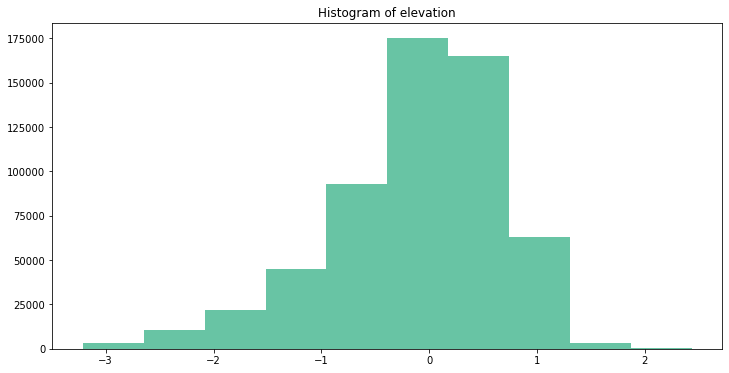

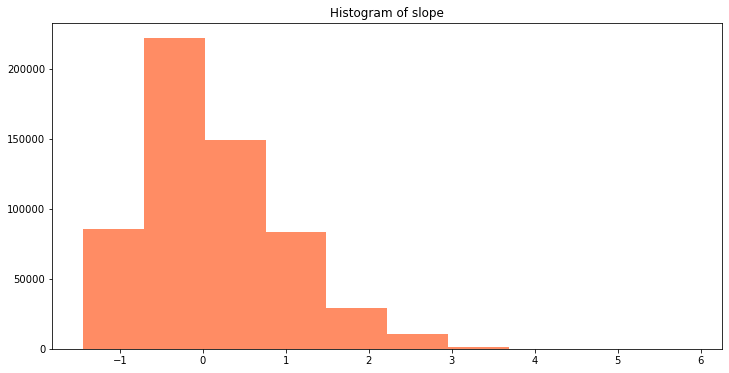

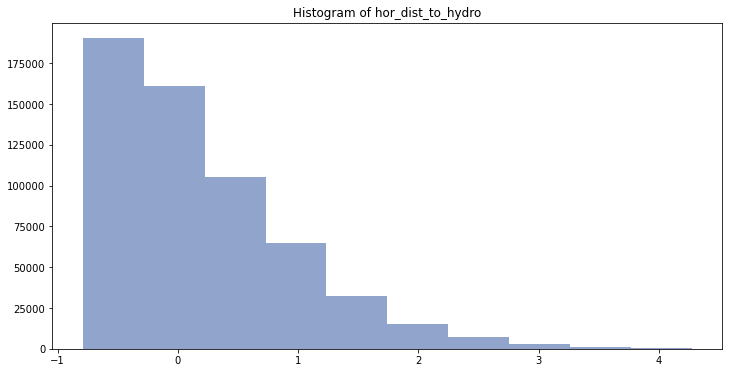

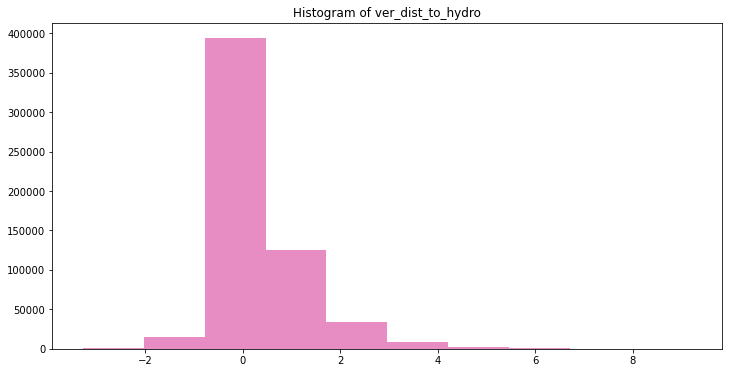

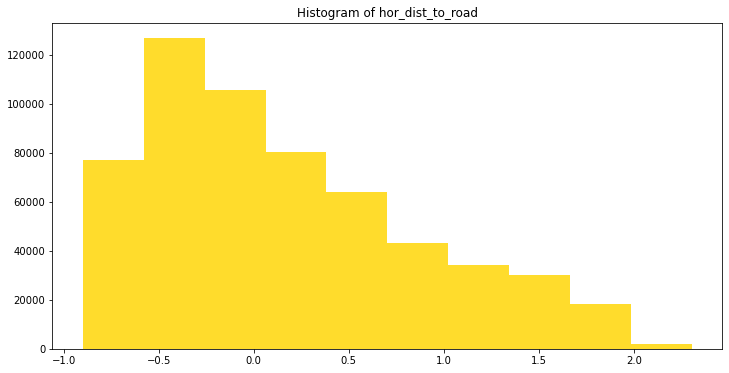

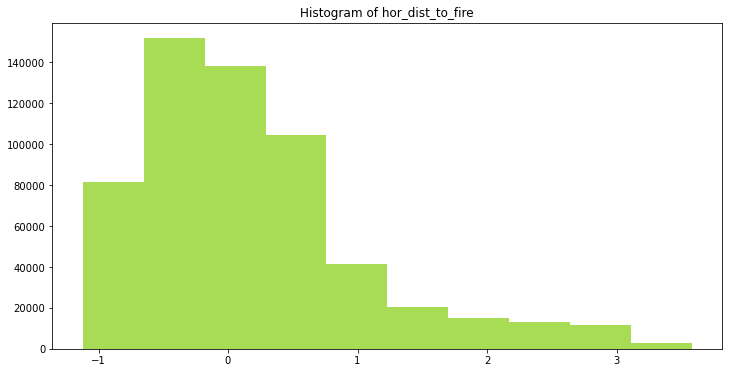

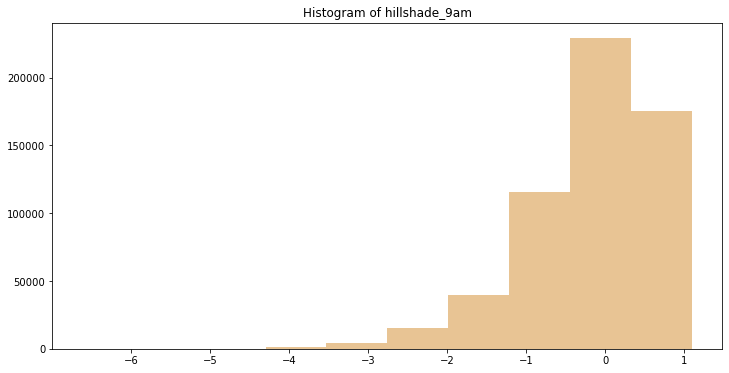

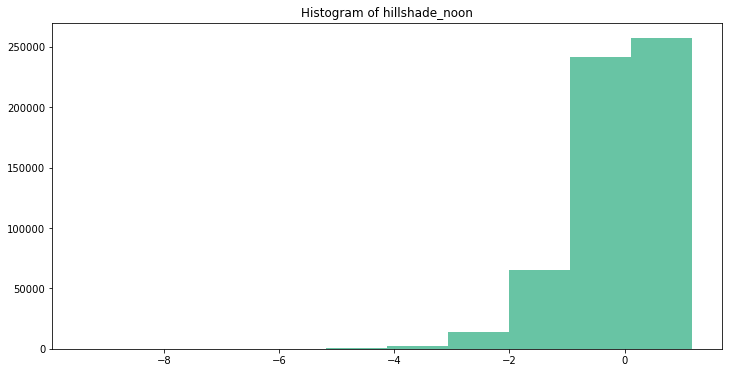

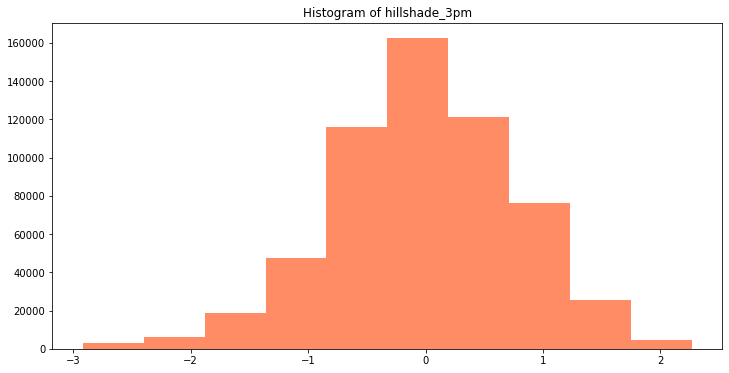

In [10]:
# Interate through features
counter = 0
for feature in transformed_df.columns.tolist():

    # Determine if feature is qualitative
    if transformed_df[feature].dtype == "float64":
        # Plot histogram
        plt.rcParams["figure.figsize"] = (12,6)
        plt.figsize = (12,6)
        fig = plt.hist(transformed_df[feature], color=color_list[counter % len(color_list)])
        plt.title("Histogram of {}".format(feature))
        plt.show()
        counter += 1

<h3>Load data</h3>

The transformed dataframe is outputted as a .pkl for use in upcoming <i>Feature Engineering</i> phase.

In [11]:
# Output to csv
file_name = "transformed_cover_type.pkl" 
transformed_df.to_pickle(data_dir + file_name)